In [ ]:
!pip install py7zr
!pip install -q opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.5 MB/s eta 0:00:00


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/wordroid/cifar10-object-recognition-in-images-zip-file/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bhardwajdivyanshu
Your Kaggle Key: ··········


100%|██████████| 1.54G/1.54G [00:15<00:00, 107MB/s] 


In [ ]:
import numpy as np
import pandas as pd
from py7zr import unpack_7zarchive
import shutil


In [ ]:
shutil.unpack_archive('/content/cifar10-object-recognition-in-images-zip-file/train_test/train.zip', '/content/train')

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

In [ ]:
train_labels=pd.read_csv("/content/cifar10-object-recognition-in-images-zip-file/trainLabels.csv", header='infer')

classes=train_labels['label'].unique()
print(classes)

name2num={}
i=0
for name in classes:
    name2num[name]=i
    i=i+1

num2name={}
for i in range(len(classes)):
    num2name[i]=classes[i]

['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']


In [ ]:
class TrainDataset(Dataset):
    def __init__(self, imgpath, labelpath):
        super().__init__()
        self.imgpath=imgpath
        self.labelpath=labelpath
        self.labels=pd.read_csv(labelpath, header='infer')
        self.transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self,idx):
        finalpath=os.path.join(self.imgpath,str(idx+1))+'.png'
        img=read_image(finalpath)/255
        img=self.transform(img)
        label=self.labels.iloc[idx,1]
        label=name2num[label]
        return img,label

traindataset=TrainDataset('/content/train/train','/content/cifar10-object-recognition-in-images-zip-file/trainLabels.csv')

batch_size=64
traindataloader=DataLoader(dataset=traindataset, batch_size=batch_size)

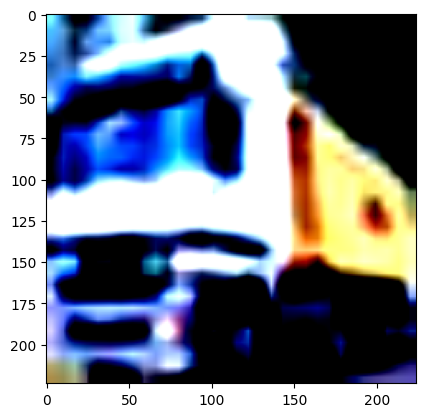

1


In [ ]:
img = traindataset[1][0]
arrimg = img.permute(1, 2, 0).numpy()
plt.imshow(arrimg)
plt.show()
print(traindataset[1][1])

In [ ]:
class Cifar10Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrainednet=mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

        # Do not back propogate in early layers od MobileNet, specific 3 layers
        for param in self.pretrainednet.features[:4].parameters():
            param.requires_grad = False
        for param in self.pretrainednet.features[4:].parameters():
            param.requires_grad = True

        self.pretrainednet.classifier=nn.Sequential(
            nn.Linear(in_features=960, out_features=1280,
                   bias=True),nn.Hardswish(),
            nn.Dropout(p=0.2, inplace=True),
            # nn.Linear(in_features=1280, out_features=1000,
            #        bias=True),nn.Hardswish(),
            nn.Linear(in_features=1280, out_features=10,
                      bias=True)
        )

    def forward(self,x):
        x=self.pretrainednet(x)
        return x

In [ ]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    num_correct=0
    num_param=0

    for i, (imgs, labels) in enumerate(dataloader):
        imgs=imgs.to(device)
        labels=labels.to(device)
        pred=model(imgs)

        loss=loss_fn(pred,labels)
        track_loss+=loss.item()
        num_correct+=(torch.argmax(pred,dim=1)==labels).type(torch.float).sum().item()

        running_loss=round(track_loss/(i+(imgs.shape[0]/batch_size)),2)
        running_acc=round((num_correct/((i*batch_size+imgs.shape[0])))*100,2)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100==0:
            print("Batch:", i+1, "/",len(dataloader), "Running Loss:",running_loss, "Running Accuracy:",running_acc)

    epoch_loss=running_loss
    epoch_acc=running_acc
    return epoch_loss, epoch_acc

In [ ]:
model=Cifar10Net()
model=model.to(device)
print(model)

# for param in model.pretrainednet.features.parameters():
#     param.requires_grad=True

loss_fn=nn.CrossEntropyLoss()
lr=0.001
#optimizer=torch.optim.SGD(params=model.parameters(), lr=lr)
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=10

Cifar10Net(
  (pretrainednet): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActi

In [ ]:
for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(traindataloader,model,loss_fn,optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")

# for param in model.pretrainednet.features.parameters():
#     param.requires_grad=True

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_acc=train_one_epoch(traindataloader,model,loss_fn,optimizer)
    print("Training:", "Epoch Loss:", train_epoch_loss, "Epoch Accuracy:", train_epoch_acc)
    print("--------------------------------------------------")

Epoch No: 1
Batch: 1 / 782 Running Loss: 2.29 Running Accuracy: 12.5
Batch: 101 / 782 Running Loss: 0.72 Running Accuracy: 76.13
Batch: 201 / 782 Running Loss: 0.57 Running Accuracy: 80.83
Batch: 301 / 782 Running Loss: 0.51 Running Accuracy: 83.05
Batch: 401 / 782 Running Loss: 0.47 Running Accuracy: 84.41
Batch: 501 / 782 Running Loss: 0.44 Running Accuracy: 85.31
Batch: 601 / 782 Running Loss: 0.42 Running Accuracy: 85.93
Batch: 701 / 782 Running Loss: 0.4 Running Accuracy: 86.55
Training: Epoch Loss: 0.39 Epoch Accuracy: 86.94
--------------------------------------------------
Epoch No: 2
Batch: 1 / 782 Running Loss: 0.18 Running Accuracy: 89.06
Batch: 101 / 782 Running Loss: 0.22 Running Accuracy: 92.54
Batch: 201 / 782 Running Loss: 0.22 Running Accuracy: 92.58
Batch: 301 / 782 Running Loss: 0.22 Running Accuracy: 92.65
Batch: 401 / 782 Running Loss: 0.21 Running Accuracy: 92.85
Batch: 501 / 782 Running Loss: 0.21 Running Accuracy: 93.04
Batch: 601 / 782 Running Loss: 0.2 Running

KeyboardInterrupt: 

In [ ]:
shutil.unpack_archive('/content/cifar10-object-recognition-in-images-zip-file/train_test/test.zip', '/content/train')


In [ ]:
class TestDataset(Dataset):
    def __init__(self, imgpath):
        super().__init__()
        self.imgpath=imgpath
        _,_,self.files=next(os.walk(self.imgpath))
        self.length=len(self.files)
        self.transform=Compose([Resize((224,224), antialias=True), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return self.length

    def __getitem__(self,idx):
        finalpath=os.path.join(self.imgpath,str(idx+1))+'.png'
        img=read_image(finalpath)/255.0
        img=self.transform(img)
        return img

testdataset=TestDataset('/content/train/test')
testdataloader=DataLoader(dataset=testdataset, batch_size=batch_size)

In [ ]:
def eval(dataloader, model,loss_fn, path):
    model.eval()
    data=pd.read_csv(path)
    with torch.no_grad():
        for i, imgs in enumerate(dataloader):
            finalbatchpred=np.zeros(imgs.shape[0],dtype='object')
            imgs=imgs.to(device)
            pred=model(imgs)

            pred=torch.argmax(pred,dim=1).type(torch.int).cpu()
            for j,p in enumerate(pred):
                finalbatchpred[j]=num2name[p.item()]
            data.iloc[i*batch_size:i*batch_size+batch_size ,1]=finalbatchpred

    data.to_csv('submission.csv', index=False)
    data.head()

In [ ]:
eval(test_dataloader, model,loss_fn, '/content/cifar10-object-recognition-in-images-zip-file/sampleSubmission.csv')